# Milestone 2 Supervised Portion - Text Difficulty Classification


## Formal Project Description
In many real-world applications, there is a need to make sure textual information is comprehensible/readable by audiences who may not have high reading proficiency. This might include students, children, adults with learning/reading difficulties, and those who have English as a second language. The Simple English Wikipedia (https://en.wikipedia.org/wiki/Simple_English_Wikipedia), for example, was created exactly for this purpose. Before the editors spend a lot of effort to simplify the text and increase its readability, it would be very useful to suggest to them which parts of an article's text might need to be simplified.

This notebook develops and trains a Multinomial Naive Bayes classifier, a logistic regression model, and gradient boosted decision trees classifier to address the challenge of binary text classification. 

Sentences from Wikipedia articles are classified into one of two categories:

0: the sentence does NOT need to be simplified.

1: the sentence DOES need to be simplified.


The training data contains 416,768 sentences, already labeled with one of the above categories. The test data contains 119,092 comments that are unlabeled. (The test data is strictly used for the class pseudo competition.)

## 1.) Load & Clean the Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

In [2]:
#Import the datasets
# File descriptions
#   WikiLarge_Train.csv - the training set
#   WikiLarge_Test.csv - the test set (without labels)

# Data fields in training/test sets
#   id - a unique identifier for each example. This should match with the Id field of the submission file. It should be in the range 0-119,091.
#   text - the actual sentence of each training/test example. It's free-form text.
#   label - the class label of a training example: either 0 or 1.

wikilarge_train = pd.read_csv('assets/WikiLarge_Train.csv', encoding= 'unicode_escape')
#wikilarge_test = pd.read_csv('assets/WikiLarge_Test.csv', encoding= 'unicode_escape') For Kaggle-esque competition only

In [3]:
wikilarge_train.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


## 2.) Generate Features

External features I will get cover age of acquisition, concreteness, Dale Chall readability, parts of speech, syllables, if-idf, and Word2Vec Representations.

### Age of Acquisition

The AoA_51715_words.csv contains "Age of Acquisition" (AoA) estimates for about 51k English words, which refers to the approximate age (in years) when a word was learned. Early words, being more basic, have lower average AoA, so I hypothesize that if you average the AOAs of all words, easier documents to read will have lower numbers. (AoA_kup_lem is the only one without empty rows). 

The 51715 words that have values for AoA are stored in the dictionary, aoa_dict. (as well as syllable counts, we'll get to that later)
Ultimately, the percent of applicable words that have aoa values under 5, 10, 15, 20, or more will be represented as a feature, as well as the average AoA value.

In [4]:
aoa = pd.read_csv('assets/AoA_51715_words.csv', encoding= 'unicode_escape')
#Remove Na
aoa = aoa[['Word', 'AoA_Kup_lem', 'Nsyll']].dropna()
#Word as the key, [AoA, num_syllables] as the values
aoa_dict = dict(zip(aoa.Word, zip(aoa.AoA_Kup_lem.astype(float), aoa.Nsyll.astype(float))))

### Extract Concreteness Ratings
Concreteness evaluates the degree to which the concept denoted by a word refers to a
perceptible entity. The variable came to the foreground in Paivio’s dual-coding theory (Paivio,
1971, 2013). According to this theory, concrete words are easier to remember than abstract
words, because they activate perceptual memory codes in addition to verbal codes. 

A concrete word comes with a higher rating and refers to something that exists in reality; you
can have immediate experience of it through your senses (smelling, tasting, touching, hearing,
seeing) and the actions you do. Hence, having more words with a higher concreteness value would make a sentence simpler. 

Not all words have a concreteness value, so the feature that will be represented is the average of all the words that do.

In [5]:
concreteness = pd.read_csv('assets/Concreteness_ratings_Brysbaert_et_al_BRM.txt', delimiter = "\t")
conc_dict = dict(zip(concreteness.Word, list(zip(concreteness['Conc.M'].astype(float), concreteness['Percent_known'].astype(float), concreteness['SUBTLEX'].astype(float)))))

### Dale Chall Readability
The Dale-Chall Word List contains approximately three thousand familiar words that are known in reading by at least 80 percent of the children in Grade 5. It gives a significant correlation with reading difficulty. It is not intended as a list of the most important words for children or adults. It includes words that are relatively unimportant and excludes some important ones.

Dale Chall Readability is represented as the percentage of words in the given text that is in the Dale Chall list.

In [6]:
dale_chall_list = pd.read_csv('assets/dale_chall.txt').values.flatten().tolist()

### Syllable Counts

Syllables are the phonological building blocks of words and are single units of speech, either as a whole word or one of the parts into which a word can be separated. They sually contain a vowel. Naturally, words with more syllables are more complex.

For this data, the percentages of words that have one through four syllables and more than 5 syllables are represented, as well as the average syllable count for the sentence.

The NLTK library provides the most accurate means of getting syllable count; however, using NLTK is inefficient, so I opt to first check the AOA dictionary first to see if syllable counts are there. Lastly, if a syllable is not even accounted for, the get_syllables_last_resort function algorithmically determines the syllable count based off of vowels, although this method can be inaccurate for exceptional words.

In [7]:
import nltk
from nltk.data import load
from nltk.corpus import cmudict
import syllables

#Carnegie Mellon Dictionary is the best resource for getting syllables, but it demands a for loop
best_syllables = cmudict.dict()

def count_syllables(word_s):
    #The Carnegie Mellon dict is the best way to get syllables that aren't readily available in the AoA dict
    count = 0
    phones = best_syllables[word_s] # this returns a list of matching phonetic rep's
    if phones:                   # if the list isn't empty (the word was found)
        phones0 = phones[0]      #     process the first
        count = len([p for p in phones0 if p[-1].isdigit()]) # count the vowels
    return count

def get_syllables_last_resort(word):
    #algorithm shamelessly stolen from https://medium.com/@mholtzscher/programmatically-counting-syllables-ca760435fab4
    # '60% of the time, it works every time' - Only use for words not in CMU or AoA dictionaries
    syllable_count = 0
    vowels = 'aeiouy'
    if word[0] in vowels:
        syllable_count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            syllable_count += 1
    if word.endswith('e'):
        syllable_count -= 1
    if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
        syllable_count += 1
    if syllable_count == 0:
        syllable_count += 1

### Additional Features and Data Extraction (Length of Text, Word Counts, Word Length, Recognizability, and Parts of Speech)

The extract features function mines the Wikipedia documents for age of acquisition, concreateness, dale chall readability, syllable groups. Additionally, it finds the length of the text, the average word length, the percent of recognizable words (found in concreteness df), and percentage of words for each part of speech. Parts of Speech are the categories to which a word is assigned in accordance with its syntactic functions. They are essential for breaking down the structure of text, so I figured it wouldn't hurt to add them in as features.

This is a gnarly function that takes between 20-30 minutes to run, so future edits to this notebook include optimizing this function, breaking it up, or accomplishing the same thing with a task.

In [8]:
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from collections import Counter, defaultdict


lemmatizer = WordNetLemmatizer()


def extract_features(df):
    avg_aoa_scores = []
    concreteness = []
    percent_dale_chall = []
    word_count = [] 
    avg_word_length = [] 
    avg_syllables = [] 
    syllable_groups = {'1 Syll':[], '2 Syll':[], '3 Syll':[],'4 Syll':[], '>=5 Syll':[]}
    avg_percent_recognized = []
    aoa_total_groups = {'aoa<=5':[],'aoa<=10':[],'aoa<=15':[],'aoa<=20':[],'aoa>20':[]}
    
    #Create dictionary to hold percentages of all NLTK parts of speech for each entry
    possible_pos = ['LS', 'TO', 'VBN', 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(',
                    ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 
                    'SYM', 'CC', 'CD', 'POS']                                             #Found from load('help/tagsets/upenn_tagset.pickle').keys()
    total_pos = defaultdict(list)
    for pos in possible_pos:
        total_pos[pos] = []
        
    #Use NLTK word_tokenize to get tokenized text, as well as lemmatized text
    for text in df['original_text']:
        tokens = [word.lower() for word in word_tokenize(text)]
        len_tokens = float(len(tokens))
        #Append number of words to word_count
        word_count.append(len_tokens)
        #lemmas are used for concreteness
        
        #Extract POS
        text_pos_count = Counter() #Create dictionary
        # create key for every pos, so that AT LEAST 0 is returned to the corpus list
        for pos in possible_pos:    
            text_pos_count[pos] = 0.0
        #Use NLTK pos_tag to extract POS
        for word, pos in pos_tag(tokens):
            if pos in possible_pos: #Some useless POS may exist in new text
                text_pos_count[pos] += 1
        #Append the percentage for each POS in this entry to the total pos_dictionary
        for key, val in text_pos_count.items():
            val_normalized = val / len_tokens
            total_pos[key].append(val_normalized)
        
        lemmas = []
        num_dale_chall = 0.0
        word_lengths = []
        syllables = []
        for token in tokens:
            word_lengths.append(len(token))
            #Use AoA to get syllable length (second value in list)
            if token not in aoa_dict.keys():
                try:
                    syllables.append(float(count_syllables(token)))
                except:
                    try:
                        syllables.append(float(get_syllables_last_resort(token))) #Use the NLTK syllable extractor for unique situations
                    except:
                        syllables.append(1) #Absolute worst case scenario, nothing can find syllables
            else:
                  syllables.append(float(aoa_dict[token][1]))
            
            #lemmas need to be found, as that's what the conc dictionary uses
            lemma = lemmatizer.lemmatize(token)
            lemmas.append(lemmatizer.lemmatize(token))
            #If token is in Dale Chall list, add one to num_dale_chall (Making assumption that numbers add to readability)
            if token in dale_chall_list or token.isnumeric():
                num_dale_chall += 1
                
        #Calculate mean word length
        avg_word_length.append(np.mean(word_lengths))
        #Find counts of words with each syllable... 
        if len(syllables) > 0:
            #Get avg syllable count
            avg_syllables.append(np.mean(syllables))
            #Add counts 
            sub_syllable_groups = {'1 Syll':0, '2 Syll':0, '3 Syll':0,'4 Syll':0, '>=5 Syll':0}
            for syll in syllables:
                if syll == 1:
                    sub_syllable_groups['1 Syll'] +=1
                elif syll == 2:
                    sub_syllable_groups['2 Syll'] +=1
                elif syll == 3:
                    sub_syllable_groups['3 Syll'] +=1
                elif syll == 4:
                    sub_syllable_groups['4 Syll'] +=1
                else:
                    sub_syllable_groups['>=5 Syll'] +=1
            #Add percentage of words falling in each age of acquisition group back into list for text
            [syllable_groups[key].append(val / len(syllables)) for key, val in sub_syllable_groups.items()]
        else:
            #Add zeros to percentage of syllables
            [syllable_groups[key].append(0) for key in syllables.keys()]
            avg_syllables.append(0)

        #Get Aoa Scores for each lemma, and find the average... If there are none, pass, and pray outliers won't trow off models too much
        #Get avg concreteness scores, subtlex, and percent recognized, too at the same time :)
        aoas = []
        conc = []
        subtlex_list = []
        percents_known_list = []
        for lemma in lemmas:
            try:
                #Get aoa score
                aoas.append(aoa_dict[lemma][0])
            except:
                pass
            try:
                #concreteness df doesn't have empty rows, so we're clear to do this in the same, try/except
                conc.append(conc_dict[lemma][0])
                percents_known_list.append(conc_dict[lemma][1])
            except:
                if lemma.isnumeric(): #account for numbers that are easy to read
                    conc.append(5)
                    percents_known_list.append(.99) #I bet near 100% know a number
                else:
                    pass
            
        #Find average aoa and append to list for each text entry
        sub_aoa_groups = {'aoa<=5':0,'aoa<=10':0,'aoa<=15':0,'aoa<=20':0,'aoa>20':0}
        if len(aoas) > 0:
            avg_aoa_scores.append(np.mean(aoas))
            #Add counts 
            for aoa in aoas:
                if aoa <= 5:
                    sub_aoa_groups['aoa<=5'] +=1
                elif aoa <= 10:
                    sub_aoa_groups['aoa<=10'] +=1
                elif aoa > 10 and aoa <= 15:
                    sub_aoa_groups['aoa<=15'] +=1
                elif aoa > 15 and aoa <= 20:
                    sub_aoa_groups['aoa<=20'] +=1
                else:
                    sub_aoa_groups['aoa>20'] +=1
            #Add percentage of words falling in each age of acquisition group back into list for text
            [aoa_total_groups[key].append(val / len(aoas)) for key, val in sub_aoa_groups.items()]
        else:
            avg_aoa_scores.append(0) #Usually weird words... or non-words... should be labeled as easy
            #Add zeros to percentage of word AOAs
            [aoa_total_groups[key].append(0) for key in sub_aoa_groups.keys()]
            
        #Append average concreteness, subtlex, and percent known for each entry
        if len(conc) > 0:
            concreteness.append(np.mean(conc))
        else:
            concreteness.append(0) #Less concrete words have a smaller value, anyway
        if len(percents_known_list) > 0:
            avg_percent_recognized.append(np.mean(percents_known_list))
        else:
            avg_percent_recognized.append(0)
            
        #Now for Dale Chall
        percent_dale_chall.append(num_dale_chall / len_tokens)
                
    return avg_aoa_scores, concreteness, percent_dale_chall, word_count, avg_word_length, avg_syllables, avg_percent_recognized, dict(total_pos), aoa_total_groups, syllable_groups

The below code mines the features for the training and (Kaggle competition) test datasets

In [9]:
train_aoa, train_concreteness, train_dalechall, train_wordcount, train_avg_word_length, train_avg_syllables, train_avg_percent_recognized, train_perc_pos_dict, train_aoa_dict, train_syllable_dict = extract_features(wikilarge_train)

In [10]:
#test_aoa, test_concreteness, test_dalechall, test_wordcount, test_avg_word_length, test_avg_syllables, test_avg_percent_recognized, test_perc_pos_dict, test_aoa_dict, test_syllable_dict = extract_features(wikilarge_test)

The below line of code places the features in their respectibe dataframes. The "Test" df is for the pseudo Kaggle competition only, so it is commented out.

In [11]:
#Add columns for aoa scores
#wikilarge_train = wikilarge_train[]# --------- For testing purposes

#Create a pandas column for each POS percentage
for pos, percentages in train_perc_pos_dict.items():
    wikilarge_train[pos] = percentages

#Create a column for percents of words in each age of acquisition group
for aoa_group, percentages in train_aoa_dict.items():
    wikilarge_train[aoa_group] = percentages
    
#Create a column for percents of words in each number of syllables group
for syll_group, percentages in train_syllable_dict.items():
    wikilarge_train[syll_group] = percentages

    
wikilarge_train['avg_aoa_score'] = train_aoa
wikilarge_train['avg_concreteness'] = train_concreteness
wikilarge_train['perc_dale_shall'] = train_dalechall
wikilarge_train['num_words'] = train_wordcount
wikilarge_train['avg_word_length'] = train_avg_word_length
wikilarge_train['avg_syllable_count'] = train_avg_syllables
wikilarge_train['avg_percent_recognized'] = train_avg_percent_recognized


####################################For the Kaggle test DF

# #Create a pandas column for each POS percentage
# for pos, percentages in test_perc_pos_dict.items():
#     wikilarge_test[pos] = percentages

# #Create a column for percents of words in each age of acquisition group
# for aoa_group, percentages in test_aoa_dict.items():
#     wikilarge_test[aoa_group] = percentages
    
# #Create a column for percents of words in each number of syllables group
# for syll_group, percentages in test_syllable_dict.items():
#     wikilarge_test[syll_group] = percentages
    
# wikilarge_test['avg_aoa_score'] = test_aoa
# wikilarge_test['avg_concreteness'] = test_concreteness
# wikilarge_test['perc_dale_shall'] = test_dalechall
# wikilarge_test['num_words'] = test_wordcount
# wikilarge_test['avg_word_length'] = test_avg_word_length
# wikilarge_test['avg_syllable_count'] = test_avg_syllables
# wikilarge_test['avg_percent_recognized'] = test_avg_percent_recognized

#Data mining each time is painful... The below code saves the processed csv for more convenient use.
#wikilarge_train = pd.read_csv('assets/processed_train.csv')

wikilarge_train.head()
#wikilarge_test.head()

,original_text,label,LS,TO,VBN,WP,UH,VBG,JJ,VBZ,--,VBP,NN,DT,PRP,:,WP$,NNPS,PRP$,WDT,(,),.,",",``,$,RB,RBR,RBS,VBD,IN,FW,RP,JJR,JJS,PDT,MD,VB,WRB,NNP,EX,NNS,SYM,CC,CD,POS,aoa<=5,aoa<=10,aoa<=15,aoa<=20,aoa>20,1 Syll,2 Syll,3 Syll,4 Syll,>=5 Syll,avg_aoa_score,avg_concreteness,perc_dale_shall,num_words,avg_word_length,avg_syllable_count,avg_percent_recognized
0,There is manuscript evidence that Austen conti...,1,0.0,0.023256,0.023256,0.000000,0.0,0.000000,0.046512,0.046512,0.0,0.000000,0.139535,0.046512,0.000000,0.000000,0.0,0.0,0.023256,0.023256,0.0,0.0,0.023256,0.069767,0.0,0.0,0.139535,0.0,0.000000,0.023256,0.093023,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.023256,0.069767,0.0,0.069767,0.069767,0.000000,0.413793,0.517241,0.068966,0.0,0.0,0.720930,0.162791,0.116279,0.000000,0.000000,5.481034,2.691562,0.558140,43.0,4.046512,1.395349,0.985938
1,"In a remarkable comparative analysis , Mandaea...",1,0.0,0.043478,0.043478,0.000000,0.0,0.000000,0.173913,0.000000,0.0,0.000000,0.260870,0.043478,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.043478,0.043478,0.0,0.0,0.043478,0.0,0.000000,0.086957,0.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.043478,0.285714,0.428571,0.285714,0.0,0.0,0.608696,0.173913,0.043478,0.173913,0.000000,7.499286,2.436429,0.217391,23.0,5.826087,1.782609,0.995000
2,"Before Persephone was released to Hermes , who...",1,0.0,0.108696,0.065217,0.021739,0.0,0.043478,0.021739,0.021739,0.0,0.000000,0.152174,0.086957,0.043478,0.000000,0.0,0.0,0.021739,0.021739,0.0,0.0,0.021739,0.065217,0.0,0.0,0.000000,0.0,0.000000,0.086957,0.065217,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.043478,0.0,0.021739,0.043478,0.000000,0.472222,0.500000,0.027778,0.0,0.0,0.717391,0.195652,0.065217,0.021739,0.000000,5.328056,2.446471,0.543478,46.0,4.413043,1.391304,0.992647
3,Cogeneration plants are commonly found in dist...,1,0.0,0.000000,0.025641,0.000000,0.0,0.051282,0.051282,0.000000,0.0,0.025641,0.230769,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.025641,0.153846,0.0,0.0,0.025641,0.0,0.000000,0.025641,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.282051,0.0,0.025641,0.000000,0.000000,0.310345,0.551724,0.137931,0.0,0.0,0.564103,0.256410,0.102564,0.051282,0.025641,6.768276,3.430645,0.256410,39.0,5.333333,1.717949,0.994516
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.055556,0.0,0.000000,0.305556,0.083333,0.000000,0.111111,0.0,0.0,0.000000,0.000000,0.0,0.0,0.027778,0.083333,0.0,0.0,0.000000,0.0,0.027778,0.000000,0.138889,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.055556,0.000000,0.000000,0.533333,0.400000,0.066667,0.0,0.0,0.805556,0.083333,0.111111,0.000000,0.000000,5.396667,2.364667,0.361111,36.0,4.638889,1.305556,0.989333


### Scale the Data

The features contain data that are of different magnitudes, so min-max scaling is applied to bring the data within the range of 0-1.

In [12]:
#Don't forget to normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Used when concatenating the above df with further tf-idf/ word2vec features
columns_to_concat_in = ['LS', 'TO', 'VBN', 'WP', 'UH', 'VBG', 'JJ',
                       'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$',
                       'WDT', '(', ')', '.', ',', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN',
                       'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS',
                       'SYM', 'CC', 'CD', 'POS', 'aoa<=5', 'aoa<=10', 'aoa<=15', 'aoa<=20',
                       'aoa>20', '1 Syll', '2 Syll', '3 Syll', '4 Syll', '>=5 Syll',
                       'avg_aoa_score', 'avg_concreteness', 'perc_dale_shall', 'num_words',
                       'avg_word_length', 'avg_syllable_count', 'avg_percent_recognized']

columns_to_scale = ['avg_aoa_score', 'avg_concreteness', 'num_words', 
                    'avg_word_length', 'avg_syllable_count',] #Keep out columns with percents, they're already scaled

all_columns = ['original_text', 'LS', 'TO', 'VBN', 'WP', 'UH', 'VBG', 'JJ',
                       'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$',
                       'WDT', '(', ')', '.', ',', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN',
                       'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS',
                       'SYM', 'CC', 'CD', 'POS', 'aoa<=5', 'aoa<=10', 'aoa<=15', 'aoa<=20',
                       'aoa>20', '1 Syll', '2 Syll', '3 Syll', '4 Syll', '>=5 Syll',
                       'avg_aoa_score', 'avg_concreteness', 'perc_dale_shall', 'num_words',
                       'avg_word_length', 'avg_syllable_count', 'avg_percent_recognized']

wikilarge_train[columns_to_scale] = scaler.fit_transform(wikilarge_train[columns_to_scale])
#wikilarge_test[columns_to_scale] = scaler.fit_transform(wikilarge_test[columns_to_scale])

In [13]:
 wikilarge_train.head()

,original_text,label,LS,TO,VBN,WP,UH,VBG,JJ,VBZ,--,VBP,NN,DT,PRP,:,WP$,NNPS,PRP$,WDT,(,),.,",",``,$,RB,RBR,RBS,VBD,IN,FW,RP,JJR,JJS,PDT,MD,VB,WRB,NNP,EX,NNS,SYM,CC,CD,POS,aoa<=5,aoa<=10,aoa<=15,aoa<=20,aoa>20,1 Syll,2 Syll,3 Syll,4 Syll,>=5 Syll,avg_aoa_score,avg_concreteness,perc_dale_shall,num_words,avg_word_length,avg_syllable_count,avg_percent_recognized
0,There is manuscript evidence that Austen conti...,1,0.0,0.023256,0.023256,0.000000,0.0,0.000000,0.046512,0.046512,0.0,0.000000,0.139535,0.046512,0.000000,0.000000,0.0,0.0,0.023256,0.023256,0.0,0.0,0.023256,0.069767,0.0,0.0,0.139535,0.0,0.000000,0.023256,0.093023,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.023256,0.069767,0.0,0.069767,0.069767,0.000000,0.413793,0.517241,0.068966,0.0,0.0,0.720930,0.162791,0.116279,0.000000,0.000000,0.288475,0.538312,0.558140,0.461538,0.117174,0.056478,0.985938
1,"In a remarkable comparative analysis , Mandaea...",1,0.0,0.043478,0.043478,0.000000,0.0,0.000000,0.173913,0.000000,0.0,0.000000,0.260870,0.043478,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.043478,0.043478,0.0,0.0,0.043478,0.0,0.000000,0.086957,0.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.043478,0.285714,0.428571,0.285714,0.0,0.0,0.608696,0.173913,0.043478,0.173913,0.000000,0.394699,0.487286,0.217391,0.241758,0.185619,0.111801,0.995000
2,"Before Persephone was released to Hermes , who...",1,0.0,0.108696,0.065217,0.021739,0.0,0.043478,0.021739,0.021739,0.0,0.000000,0.152174,0.086957,0.043478,0.000000,0.0,0.0,0.021739,0.021739,0.0,0.0,0.021739,0.065217,0.0,0.0,0.000000,0.0,0.000000,0.086957,0.065217,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.043478,0.0,0.021739,0.043478,0.000000,0.472222,0.500000,0.027778,0.0,0.0,0.717391,0.195652,0.065217,0.021739,0.000000,0.280424,0.489294,0.543478,0.494505,0.131271,0.055901,0.992647
3,Cogeneration plants are commonly found in dist...,1,0.0,0.000000,0.025641,0.000000,0.0,0.051282,0.051282,0.000000,0.0,0.025641,0.230769,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.025641,0.153846,0.0,0.0,0.025641,0.0,0.000000,0.025641,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.282051,0.0,0.025641,0.000000,0.000000,0.310345,0.551724,0.137931,0.0,0.0,0.564103,0.256410,0.102564,0.051282,0.025641,0.356225,0.686129,0.256410,0.417582,0.166667,0.102564,0.994516
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.055556,0.0,0.000000,0.305556,0.083333,0.000000,0.111111,0.0,0.0,0.000000,0.000000,0.0,0.0,0.027778,0.083333,0.0,0.0,0.000000,0.0,0.027778,0.000000,0.138889,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.055556,0.000000,0.000000,0.533333,0.400000,0.066667,0.0,0.0,0.805556,0.083333,0.111111,0.000000,0.000000,0.284035,0.472933,0.361111,0.384615,0.139957,0.043651,0.989333


### Split Data into Train, Test, and Maybe Development Sets
The StratifiedShuffleSplit module helps ensure that classes are balanced before testing.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
X = wikilarge_train[all_columns].values
y = wikilarge_train[['label']].values

sss = StratifiedShuffleSplit( n_splits=1, test_size =0.2, random_state=0)  

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## 2.) Tf-idf & Word2vec Representations

### Tf-idf (Term Frequency - Inverse Document Frequency)
A Tf-idf vectorizer numerically represents the texts by measuring term frequency and inverse document frequency. Term frequency gives weight to words that appear more often, and inverse document frequency gives more weight to words that appear in fewer documents. I hypothesize that this is advantageous due to big words that are harder to read being in fewer documents, and more simple words appearing in relatively more documents.

The Tf-idf vectorizer class from scikit-learn also allows us to remove common stopwords, put the words in lowercase, and create n-grams of the text per our choosing. Since the model is checking for readability, it is okay to put the words in lowercase, since the capitalization doesn't affect readbility, and keeping track of less words frees up memory.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Remove english stop words, put words in lowercase, using bigrams to get better performance
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, min_df=500)
X_train_tfidf = vectorizer.fit_transform(X_train[:, :1].flatten())
X_test_tfidf = vectorizer.transform(X_test[:, :1].flatten())

In [16]:
from scipy.sparse import hstack 
#This helps you concatenate features from aoa to thte tfidf vector (+1 to column for each feature)
full_X_train = hstack([X_train_tfidf, X_train[:, 1:].astype(float)])
full_X_test = hstack([X_test_tfidf, X_test[:, 1:].astype(float)])

In [17]:
full_X_train

<333414x1167 sparse matrix of type '<class 'numpy.float64'>'
	with 9177110 stored elements in COOrdinate format>

### WORD2VEC
Word2Vec provides vectorized representations of each word in the text, and words that are similar in meaning have similar representations. Additionally, the vectorized representations somehow manage to capture their meanings, semantic relationships and the different types of contexts they are used in. The context of words and how they're used may have a relationship with a difficulty to understand them, so  Word2Vec may be a fitting representation of the text.

Note: Training word2vec models can take a long time, so I used the gensim library to download a pre-trained word2vec model that transforms the text.

In [18]:
import gensim
import gensim.downloader as gensim_api

In [19]:
pre_trained_word2vec = gensim_api.load("fasttext-wiki-news-subwords-300")

The function text_to_mean_word2vec calculates the vector representations for each word with a length of 300, but becaue each text entry has several words, the mean value along the rows are taken, and 300 features are created for the average of each entry's indices.

In [20]:
def text_to_mean_word2vec(X):
    
    '''
    Takes in array of features with original text and transforms each text entry into an array that is the average of its word embeddings in the shape (1,300)
    returns the vstacked arrays of all average word embeddings in the shape (len_entries, 300)
    '''
    
    all_embeddings = []
    #Iterate over each text entry
    for text in X[:,0]:
        
        #First, tokenize the text so that word2vec can process it
        tokenized_text = [word.lower() for word in word_tokenize(text)]

        all_word_vectors = []
        #Vectorize text if it's in the pretrained model or return an array of zeros (zeros needed so that you don't take the mean of nothing)
        #Keep in mind that pre_trained_word2vec[word] gives a vector of shape (300,)
        for token in tokenized_text:
            if token in pre_trained_word2vec:
                vector = pre_trained_word2vec[token].reshape(1,-1)
            else:
                vector = np.zeros((1,300))
            all_word_vectors.append(vector)

        text_mean_vector = np.mean(np.vstack(all_word_vectors), axis=0)
        all_embeddings.append(text_mean_vector)
        
    return np.vstack(all_embeddings)

In [21]:
#Get Word Embeddings
X_train_embeddings = text_to_mean_word2vec(X_train)
X_test_embeddings = text_to_mean_word2vec(X_test)

In [22]:
#Normalize the embeddings

w2vec_scaler = MinMaxScaler()

X_train_embeddings_scaled = w2vec_scaler.fit_transform(X_train_embeddings)
X_test_embeddings_scaled = w2vec_scaler.fit_transform(X_test_embeddings)

In [23]:
#This helps you concatenate features from aoa to thte tfidf vector (+1 to column for each feature)
full_X_train_w2vec = np.hstack([X_train_embeddings_scaled, X_train[:, 2:].astype(float)])
full_X_test_w2vec = np.hstack([X_test_embeddings_scaled, X_test[:, 2:].astype(float)])

In [24]:
full_X_train_w2vec.shape

(333414, 359)

In [25]:
full_X_test_w2vec.shape

(83354, 359)

## 3.) Train & Evaluate Models

The models that will be trained and validated are as follows:

1. Naive Bayes
2. Logistic Regression
2. Gradient Boosted Decision Tree

Although accuracy is a simple measure to compare performances between models, especially when the disparity is large, accuaracy gives equal weight to false positives and false negatives, which are both considerable in a real-world setting. Hence, it is appropriate to also evaluate a model based on precision and recall. Precision calculates the ratio of true positives to all positives, making it a good metric to evaluate when seeking to minimize false positives. Recall calculates the ratio of true positives to the sum of true positives and false negatives, making it a good metric to prioritize when reducing false negatives. It is my belief that false positives can slide for this task, because a simple document marked as difficult won't give any reader a hard time, but a false negative situation that has a difficult document that was marked as simple landing in someone's haands may result in some difficulty. Recall should be optimized for, but precision should also be monitored for trade-off purposes.

Precision-recall curves and confusion matrices for each model will be generated to assist in evaluating model performance.

Confusion matrices provide a summary of a model's correct predictions along with the type 1 and type 2 errors made. Confusion matrices provide the numbers that are used to generate precision and recall.

Precision-recall curves help in visualizing the trade-offs a model makes between between precision and recall by graphing precision on the x axis and recall on the y per different probabilty thresholds for determining classes. An ideal model would have a PR curve that maximizes both precision and recall, giving a curve that reaches the upper right corner.

### Naive Bayes (Multinomial)

Our first model will be a basic Naive Bayes classifier. "Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable." (Scikit-Learn documentation) 

This assumption often doesn't hold in real life, but Naive Bayes models are fast to train, interpretable, work well with high dimensional dat, and often give a good baseline when comparing to other more-sophisticated models.

Muiltinomial is the type of Naive Bayes model used, as it is particularly well suited to textual data where each feature corresponds to an observation for each particular word, while Bernoulli is more accustomed to binary features, and Gaussian is better suited for continuous values.

#### Naive Bayes w/ Tf-idf Feature Representation

In [26]:
from sklearn.naive_bayes import MultinomialNB

#Create Multinomial Naive Bayes Classifier
nb_clf = MultinomialNB()
#Fit classifier to Tf-idf training data
nb_clf_tfidf = nb_clf.fit(full_X_train, y_train.ravel())
#Create predictions on test set
nb_tfidf_preds = nb_clf_tfidf.predict(full_X_test)

#### Evaluate Multinomial Naive Bayes w/ Tf-idf Representations

##### Multinomial Naive Bayes w/ Tf-idf Accuracy, Precision, and Recall

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Multinomial Naive Bayes (Tf-idf) Accuracy: " + str(accuracy_score(nb_tfidf_preds, y_test)))
print("Multinomial Naive Bayes (Tf-idf) Precision: " + str(precision_score(nb_tfidf_preds, y_test)))
print("Multinomial Naive Bayes (Tf-idf) Recall: " + str(recall_score(nb_tfidf_preds, y_test)))

Multinomial Naive Bayes (Tf-idf) Accuracy: 0.644948052882885
Multinomial Naive Bayes (Tf-idf) Precision: 0.6438563236317393
Multinomial Naive Bayes (Tf-idf) Recall: 0.6452652334920406


##### Multinomial Naive Bayes w/ Tf-idf Confusion Matrix

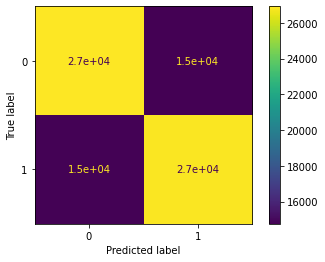

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, nb_tfidf_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

##### Multinomial Naive Bayes w/ Tf-idf Precision-Recall Curve

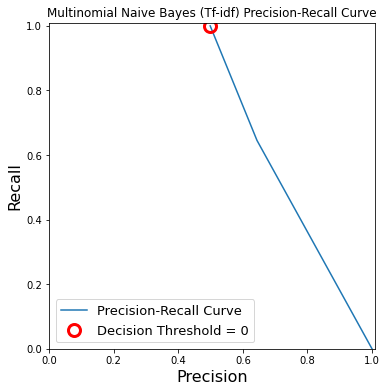

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def create_pr_curve(model_name, predicted, actual):
    
    precision, recall, thresholds = precision_recall_curve(predicted, actual)
    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]

    plt.figure(figsize=(6,6))
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.plot(precision, recall, label='Precision-Recall Curve')
    plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label='Decision Threshold = 0')
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
    plt.title(model_name)
    plt.legend(fontsize=13)
    plt.axes().set_aspect('equal')
    plt.show()
    
create_pr_curve('Multinomial Naive Bayes (Tf-idf) Precision-Recall Curve', nb_tfidf_preds, y_test)

#### Naive Bayes w/ Word2Vec Feature Representation

In [30]:
#Fit classifier to word2vec training data
nb_clf_w2vec = nb_clf.fit(full_X_train_w2vec, y_train.ravel())
#Create predictions on test set
nb_w2vec_preds = nb_clf_tfidf.predict(full_X_test_w2vec)

#### Evaluate Multinomial Naive Bayes w/ Word2Vec Representation

##### Multinomial Naive Bayes w/ W2Vec Accuracy, Precision, and Recall

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Multinomial Naive Bayes (w2vec) Accuracy: " + str(accuracy_score(nb_w2vec_preds, y_test)))
print("Multinomial Naive Bayes (w2vec) Precision: " + str(precision_score(nb_w2vec_preds, y_test)))
print("Multinomial Naive Bayes (w2vec) Recall: " + str(recall_score(nb_w2vec_preds, y_test)))

Multinomial Naive Bayes (w2vec) Accuracy: 0.6347625788804376
Multinomial Naive Bayes (w2vec) Precision: 0.700674232790268
Multinomial Naive Bayes (w2vec) Recall: 0.6190667995166522


##### Multinomial Naive Bayes w/ w2vec Confusion Matrix

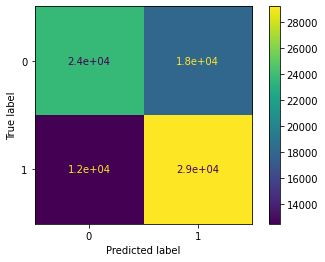

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, nb_w2vec_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

##### Multinomial Naive Bayes w/ Word2Vec Precision-Recall Curve

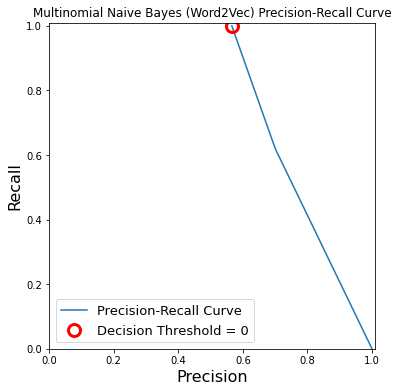

In [33]:
create_pr_curve('Multinomial Naive Bayes (Word2Vec) Precision-Recall Curve', nb_w2vec_preds, y_test)

### Logistic Regression

Logistic regression seeks to find the relationship between features and the probability of particular outcome, between 0 and 1, fitting an "s"shaped curve to the data. In the case of binary classification, such as this task, data with features that yield probability below a certain threshold fall into one category, while probabilities above a certain threshold fall into the other. Hence, because the output probabilities of logistic regression will either be closer to 1 of 2 outputs, it makes sense to try logistic regression for a binary classifcation task.

Additionally, logistic regression models are relatively simple and quick to train, so they're worthy as a next step before creating more complicated models.

#### Logistic Regression w/ Tf-idf Feature Representation

Grid Search with cross-validation is used to find the best performing C parameter. The C parameter determines the level of regularization and aids in preventing overfitting. Many grid searches were conducted, with the best C parameter being 0.565

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#Create Model
lr_clf = LogisticRegression(verbose=2, C=0.55, multi_class='ovr', n_jobs=-1, penalty='l2')

grid_values = {'C':[.56, .565, .57]} #L2 found to be best
# default metric to optimize over grid parameters: log loss
grid_lr_clf = GridSearchCV(lr_clf, param_grid = grid_values, scoring='neg_log_loss', n_jobs=-1, verbose=1, cv=3)
#Fit to Tf-idf training data
grid_lr_clf.fit(full_X_train, y_train)
grid_lr_clf.cv_results_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished


{'mean_fit_time': array([5.96649551, 5.8342789 , 5.24631596]),
 'mean_score_time': array([0.04923399, 0.04755688, 0.03942792]),
 'mean_test_score': array([-0.59994671, -0.59999722, -0.5999692 ]),
 'param_C': masked_array(data=[0.56, 0.565, 0.57],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.56}, {'C': 0.565}, {'C': 0.57}],
 'rank_test_score': array([1, 3, 2], dtype=int32),
 'split0_test_score': array([-0.59843486, -0.59846683, -0.59844184]),
 'split1_test_score': array([-0.60006358, -0.60017081, -0.60012108]),
 'split2_test_score': array([-0.6013417 , -0.60135401, -0.60134469]),
 'std_fit_time': array([0.09526536, 0.10710439, 0.8822632 ]),
 'std_score_time': array([0.00087542, 0.00250814, 0.00648781]),
 'std_test_score': array([0.00118958, 0.00118506, 0.00118994])}

In [35]:
grid_lr_clf.best_params_

{'C': 0.56}

In [36]:
#Create predictions on test set
grid_lr_clf_preds = grid_lr_clf.predict(full_X_test)

#### Evaluate Logistic Regression w/ Tf-idf Representation

In [37]:
print("Logistic Regression (Tf-idf) Accuracy: " + str(accuracy_score(grid_lr_clf_preds, y_test)))
print("Logistic Regression (Tf-idf) Precision: " + str(precision_score(grid_lr_clf_preds, y_test)))
print("Logistic Regression (Tf-idf) Recall: " + str(recall_score(grid_lr_clf_preds, y_test)))

Logistic Regression (Tf-idf) Accuracy: 0.6764162487703049
Logistic Regression (Tf-idf) Precision: 0.6831345826235093
Logistic Regression (Tf-idf) Recall: 0.6740772308639345


#### Logistic Regression w/ Tf-idf Representation - Confusion Matrix

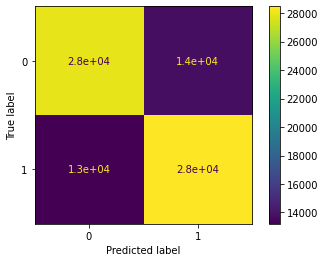

In [38]:
cm = confusion_matrix(y_test, grid_lr_clf_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

#### Logistic Regression w/ Tf-idf Representation - Precision Recall Curve

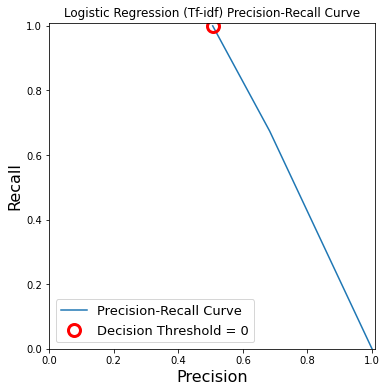

In [39]:
create_pr_curve('Logistic Regression (Tf-idf) Precision-Recall Curve', grid_lr_clf_preds, y_test)

#### Evaluate Logistic Regression w/ Word2Vec Representation

In [40]:
grid_values = {'C':[.56, .565, .57]} #L2 found to be best
# default metric to optimize over grid parameters: log loss
grid_lr_clf_w2vec = GridSearchCV(lr_clf, param_grid = grid_values, scoring='neg_log_loss', n_jobs=-1, verbose=1, cv=3)
#Fit to W2Vec training data
grid_lr_clf_w2vec.fit(full_X_train_w2vec, y_train)
grid_lr_clf_w2vec.cv_results_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.3min finished


{'mean_fit_time': array([26.55104502, 24.46938086, 22.18910313]),
 'mean_score_time': array([0.13150366, 0.13270156, 0.09965722]),
 'mean_test_score': array([-0.61258703, -0.61391193, -0.61327135]),
 'param_C': masked_array(data=[0.56, 0.565, 0.57],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.56}, {'C': 0.565}, {'C': 0.57}],
 'rank_test_score': array([1, 3, 2], dtype=int32),
 'split0_test_score': array([-0.61054578, -0.61246796, -0.61023968]),
 'split1_test_score': array([-0.61553925, -0.61648875, -0.61667385]),
 'split2_test_score': array([-0.61167605, -0.61277909, -0.61290052]),
 'std_fit_time': array([0.47653499, 0.70024713, 4.40945707]),
 'std_score_time': array([0.01684095, 0.00341324, 0.0251129 ]),
 'std_test_score': array([0.00213793, 0.00182651, 0.00263979])}

In [41]:
grid_lr_clf_w2vec.best_params_

{'C': 0.56}

In [42]:
grid_lr_clf_w2vec_preds = grid_lr_clf_w2vec.predict(full_X_test_w2vec)

In [43]:
print("Logistic Regression (Word2Vec) Accuracy: " + str(accuracy_score(grid_lr_clf_w2vec_preds, y_test)))
print("Logistic Regression (Word2Vec) Precision: " + str(precision_score(grid_lr_clf_w2vec_preds, y_test)))
print("Logistic Regression (Word2Vec) Recall: " + str(recall_score(grid_lr_clf_w2vec_preds, y_test)))

Logistic Regression (Word2Vec) Accuracy: 0.6682702689732947
Logistic Regression (Word2Vec) Precision: 0.6647071526261488
Logistic Regression (Word2Vec) Recall: 0.669478008699855


#### Logistic Regression w/ Word2Vec - Confusion Matrix

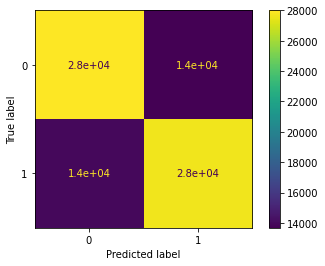

In [44]:
cm = confusion_matrix(y_test, grid_lr_clf_w2vec_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

#### Logistic Regression w/ Word2Vec Representation - Precision Recall Curve

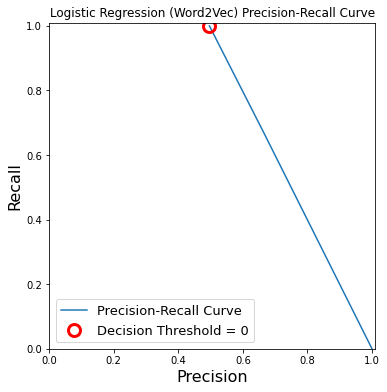

In [45]:
create_pr_curve('Logistic Regression (Word2Vec) Precision-Recall Curve', grid_lr_clf_w2vec_preds, y_test)

### Gradient Boosted Decision Trees (XGBoost)

Our last model will be a gradient boosted decision tree classifier. Gradient boosted decision trees use an ensemble of decision trees, each tree correcting the mistakes of the previous, to create powerful models. Gradient boosted decision trees often have great predictive power with a variety of features without being too demanding in regards to memory and training times. Addtionally, the XGBoost implementation is especially fast, memory-efficient, and boasts good performance. XGBoost also allows for a GPU to be used to reduce training time even more.

A grid search with cross-validation was originally conducted to determine the best parameters, but that code has been commented out to reduce the total run time of this notebook.

In [46]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier, XGBClassifier
import xgboost

# define the model (XGBoost has separate models for classifiers and regressors FYI)
xgb_model = XGBClassifier(
                          objective='binary:logistic', 
                          n_estimators=500, 
                          tree_method='gpu_hist',
                          learning_rate=0.05,
                          max_depth=25,
                          min_child_weight=1,
                          colsample_bytree=0.7,
                          n_jobs=-1          )

# optimization_dict = {"learning_rate"    : [0.05], #[0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,  
#                      "max_depth"        : [5, 10, 15, 20, 25],#[ 3, 4, 5, 6, 8, 10, 12, 15],                # The maximum depth of a tree, same as GBM.
#                      "min_child_weight" : [1],                              # Defines the minimum sum of weights of all observations required in a child. (Overfitting purposes)
#                      "colsample_bytree" : [ 0.7]}                     # Denotes the fraction of columns to be randomly samples for each tree.

# xgb_model = GridSearchCV(xgb_model, optimization_dict, 
#                       scoring='accuracy', verbose=1, cv=3)

#Fit classifier to Tf-idf training data
xgb_model.fit(full_X_train.todense(), y_train.ravel(), eval_metric='logloss', verbose=True)
#Create predictions on test set
xg_rf_preds = xgb_model.predict(full_X_test.todense())

#### Evaluate Gradient Boosted Decision Trees w/ Tf-idf Representation




In [47]:
print("Gradient Boosted Decision Trees w/ Tf-idf Representation Accuracy: " + str(accuracy_score(xg_rf_preds, y_test)))
print("Gradient Boosted Decision Trees w/ Tf-idf Representation Precision: " + str(precision_score(xg_rf_preds, y_test)))
print("Gradient Boosted Decision Trees w/ Tf-idf Representation Recall: " + str(recall_score(xg_rf_preds, y_test)))

Gradient Boosted Decision Trees w/ Tf-idf Representation Accuracy: 0.7423159056553975
Gradient Boosted Decision Trees w/ Tf-idf Representation Precision: 0.758619862274156
Gradient Boosted Decision Trees w/ Tf-idf Representation Recall: 0.7346640022306906


#### Gradient Boosted Decision Trees w/ Tf-idf Representation - Confusion Matrix


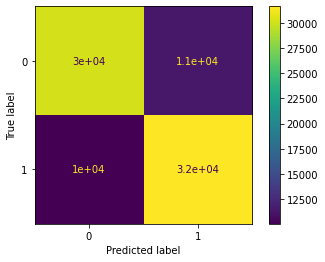

In [48]:
cm = confusion_matrix(y_test, xg_rf_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

#### Gradient Boosted Decision Trees w/ Tf-idf Representation - Precision Recall Curve


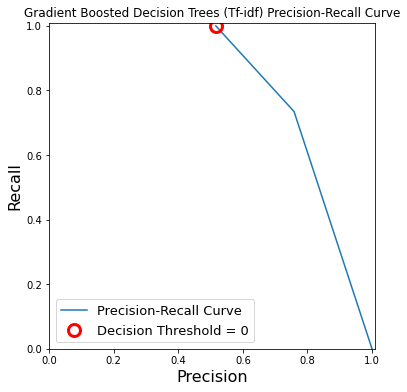

In [49]:
create_pr_curve('Gradient Boosted Decision Trees (Tf-idf) Precision-Recall Curve', xg_rf_preds, y_test)

#### Evaluate Gradient Boosted Decision Trees w/ Word2Vec Representation

In [50]:
# define the model (XGBoost has separate models for classifiers and regressors FYI)
xgb_model_w2vec = XGBClassifier(
                          objective='binary:logistic', 
                          n_estimators=500, 
                          tree_method='gpu_hist',
                          learning_rate=0.05,
                          max_depth=25,
                          min_child_weight=1,
                          colsample_bytree=0.7,
                          n_jobs=-1          )

#Fit classifier to Tf-idf training data
xgb_model_w2vec.fit(full_X_train_w2vec, y_train.ravel(), eval_metric='logloss', verbose=True)
#Create predictions on test set
xg_rf_w2vec_preds = xgb_model_w2vec.predict(full_X_test_w2vec)

In [51]:
print("Gradient Boosted Decision Trees w/ Word2Vec Representation Accuracy: " + str(accuracy_score(xg_rf_w2vec_preds, y_test)))
print("Gradient Boosted Decision Trees w/ Word2Vec Representation Precision: " + str(precision_score(xg_rf_w2vec_preds, y_test)))
print("Gradient Boosted Decision Trees w/ Word2Vec Representation Recall: " + str(recall_score(xg_rf_w2vec_preds, y_test)))

Gradient Boosted Decision Trees w/ Word2Vec Representation Accuracy: 0.6732250401900328
Gradient Boosted Decision Trees w/ Word2Vec Representation Precision: 0.5966600283129784
Gradient Boosted Decision Trees w/ Word2Vec Representation Recall: 0.7045473863153421


#### Gradient Boosted Decision Trees w/ Word2Vec Representation - Confusion Matrix



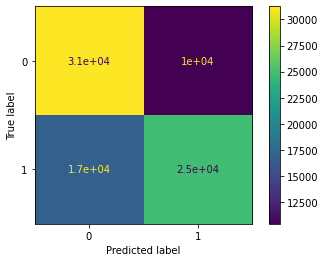

In [52]:
cm = confusion_matrix(y_test, xg_rf_w2vec_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

#### Gradient Boosted Decision Trees w/ Word2Vec Representation - Precision Recall Curve

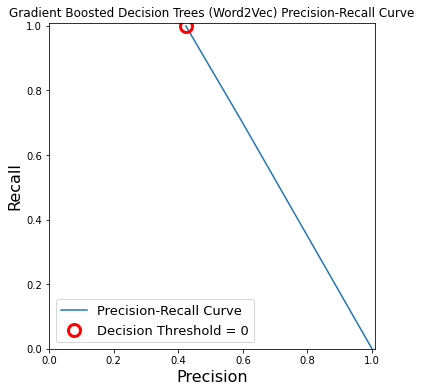

In [53]:
create_pr_curve('Gradient Boosted Decision Trees (Word2Vec) Precision-Recall Curve', xg_rf_w2vec_preds, y_test)

In [55]:
#XGBoost Preds concatenated to train df for failure analysis
train_with_xgtfidf_preds = pd.concat([wikilarge_train, pd.DataFrame(xg_rf_preds, columns=['predicted'])], axis= 1)
train_with_xgtfidf_preds.head()

,original_text,label,LS,TO,VBN,WP,UH,VBG,JJ,VBZ,--,VBP,NN,DT,PRP,:,WP$,NNPS,PRP$,WDT,(,),.,",",``,$,RB,RBR,RBS,VBD,IN,FW,RP,JJR,JJS,PDT,MD,VB,WRB,NNP,EX,NNS,SYM,CC,CD,POS,aoa<=5,aoa<=10,aoa<=15,aoa<=20,aoa>20,1 Syll,2 Syll,3 Syll,4 Syll,>=5 Syll,avg_aoa_score,avg_concreteness,perc_dale_shall,num_words,avg_word_length,avg_syllable_count,avg_percent_recognized,predicted
0,There is manuscript evidence that Austen conti...,1,0.0,0.023256,0.023256,0.000000,0.0,0.000000,0.046512,0.046512,0.0,0.000000,0.139535,0.046512,0.000000,0.000000,0.0,0.0,0.023256,0.023256,0.0,0.0,0.023256,0.069767,0.0,0.0,0.139535,0.0,0.000000,0.023256,0.093023,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.023256,0.069767,0.0,0.069767,0.069767,0.000000,0.413793,0.517241,0.068966,0.0,0.0,0.720930,0.162791,0.116279,0.000000,0.000000,0.288475,0.538312,0.558140,0.461538,0.117174,0.056478,0.985938,1.0
1,"In a remarkable comparative analysis , Mandaea...",1,0.0,0.043478,0.043478,0.000000,0.0,0.000000,0.173913,0.000000,0.0,0.000000,0.260870,0.043478,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.043478,0.043478,0.0,0.0,0.043478,0.0,0.000000,0.086957,0.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.043478,0.285714,0.428571,0.285714,0.0,0.0,0.608696,0.173913,0.043478,0.173913,0.000000,0.394699,0.487286,0.217391,0.241758,0.185619,0.111801,0.995000,1.0
2,"Before Persephone was released to Hermes , who...",1,0.0,0.108696,0.065217,0.021739,0.0,0.043478,0.021739,0.021739,0.0,0.000000,0.152174,0.086957,0.043478,0.000000,0.0,0.0,0.021739,0.021739,0.0,0.0,0.021739,0.065217,0.0,0.0,0.000000,0.0,0.000000,0.086957,0.065217,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.043478,0.0,0.021739,0.043478,0.000000,0.472222,0.500000,0.027778,0.0,0.0,0.717391,0.195652,0.065217,0.021739,0.000000,0.280424,0.489294,0.543478,0.494505,0.131271,0.055901,0.992647,0.0
3,Cogeneration plants are commonly found in dist...,1,0.0,0.000000,0.025641,0.000000,0.0,0.051282,0.051282,0.000000,0.0,0.025641,0.230769,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.025641,0.153846,0.0,0.0,0.025641,0.0,0.000000,0.025641,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.282051,0.0,0.025641,0.000000,0.000000,0.310345,0.551724,0.137931,0.0,0.0,0.564103,0.256410,0.102564,0.051282,0.025641,0.356225,0.686129,0.256410,0.417582,0.166667,0.102564,0.994516,0.0
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.055556,0.0,0.000000,0.305556,0.083333,0.000000,0.111111,0.0,0.0,0.000000,0.000000,0.0,0.0,0.027778,0.083333,0.0,0.0,0.000000,0.0,0.027778,0.000000,0.138889,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.055556,0.000000,0.000000,0.533333,0.400000,0.066667,0.0,0.0,0.805556,0.083333,0.111111,0.000000,0.000000,0.284035,0.472933,0.361111,0.384615,0.139957,0.043651,0.989333,1.0


In [56]:
train_with_xgtfidf_preds.to_csv('for_failure_analysis.csv', index=False)